In [1]:
import matplotlib.pyplot as plt
from t4gpd.io.CirReader import CirReader
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import geopandas
from math import *
from numpy.random import randint
from shapely.geometry import LineString,Point
from t4gpd.commons.GeomLib import GeomLib
from t4gpd.demos.GeoDataFrameDemos import GeoDataFrameDemos
from t4gpd.morph.geoProcesses.FootprintExtruder import FootprintExtruder
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
import random
from shapely.ops import unary_union

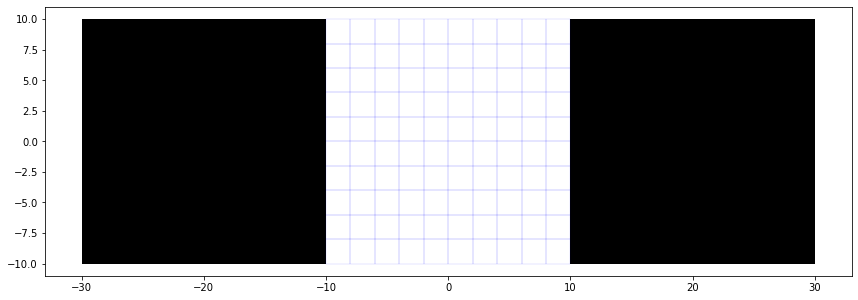

In [2]:
import matplotlib.pyplot as plt, pyvista

from geopandas import GeoDataFrame
from numpy.random import randint
from shapely.geometry import Point,Polygon
from t4gpd.commons.RayCasting3Lib import RayCasting3Lib
from t4gpd.demos.GeoDataFrameDemos import GeoDataFrameDemos
from t4gpd.morph.STGrid import STGrid

#~ ======================================================================
buildings = GeoDataFrameDemos.regularGridOfPlots(1, 2, dw=10)
hauteur = [20 for item in range(len(buildings))]
buildings['HAUTEUR'] = hauteur

dx = 2
grid = STGrid(buildings, dx, dy=None, indoor=False, intoPoint=False, encode=False).run()
grid.gid=grid.index
#ptA = Point([0,5,0])
#ptB = Point([22,20])
#points = GeoDataFrame([{'geometry': ptA, 'label': 'A'}, {'geometry': ptB, 'label': 'B'}])

#covisible, ray = RayCasting3Lib.areCovisibleIn3D(ptA, ptB, buildings, 'HAUTEUR')
#ray = GeoDataFrame([{'geometry': ray}])

fig, basemap = plt.subplots(figsize=(1.75 * 8.26, 1.2 * 8.26))
buildings.plot(ax=basemap, color='black')
grid.boundary.plot(ax=basemap, color='blue', linewidth=0.1)
#if covisible:
#	points.plot(ax=basemap, color='green')
#	ray.plot(ax=basemap, color='green')
#else:
#	points.plot(ax=basemap, color='red')
#	ray.plot(ax=basemap, color='red')
plt.show()
plt.close(fig)

In [3]:
def distance3d(point1,point2):
    d = sqrt((point1.x-point2.x)**2 + (point1.y-point2.y)**2 + (point1.z-point2.z)**2)
    return d

In [4]:
def centroid(self): #rectangle centroid
    coord = self.exterior.coords
    face_p0=np.array(coord[0])
    face_p2=np.array(coord[2])
    face_ce=(face_p0+face_p2)/2
    return Point(face_ce)

In [5]:
#transfer buildings and ground grid into 3d coordinates
op = FootprintExtruder(buildings, 'HAUTEUR', forceZCoordToZero=True)
buildingsIn3d = STGeoProcess(op, buildings).run()

def GroundGridIn3d(grid_geo):
    gridin3d = GeomLib.forceZCoordinateToZ0(grid_geo,z0=0)
    return gridin3d
grid_geo = [GroundGridIn3d(item) for item in grid.geometry]
GridIn3d = GeoDataFrame.copy(grid)
GridIn3d.geometry=grid_geo

sidewall=[]
gid=[]
fid=[]
for i in range(len(buildings)):
    base_face = GeomLib.forceZCoordinateToZ0(buildings.geometry[i],z0=0)
    roof_face = GeomLib.forceZCoordinateToZ0(buildings.geometry[i],z0=buildings.HAUTEUR[i])
    coordIn3d_base = base_face.exterior.coords
    coordIn3d_roof = roof_face.exterior.coords
    for j in range(4):
        sidewall.append(Polygon([coordIn3d_base[j+1],coordIn3d_base[j],coordIn3d_roof[j],coordIn3d_roof[j+1],coordIn3d_base[j+1]]))
        fid.append(j)
        gid.append(buildings.gid[i])
SidewallsIn3d = GeoDataFrame({'geometry':sidewall},crs='epsg:2154')
SidewallsIn3d['gid']=gid
SidewallsIn3d['fid']=fid

In [6]:
#save centroid points of each surface
grid_cen = [centroid(face_g) for face_g in GridIn3d.geometry]
GridIn3d['CentroidPoint']=grid_cen
face_cen = [centroid(face_s) for face_s in SidewallsIn3d.geometry]
SidewallsIn3d['CentroidPoint']=face_cen

In [7]:
#get diameter of the surface
def Surface_diameter(surface):
    coord = surface.exterior.coords
    d = distance3d(Point(coord[0]),Point(coord[2]))
    return d
diameter = [Surface_diameter(face_s) for face_s in SidewallsIn3d.geometry]
SidewallsIn3d['diameter'] = diameter

In [8]:
cov_grid=[]
cov_gid=[]
ran = 30
ptA = Point([-10,0,10])
bound = ptA.buffer(ran)
for i in range(len(GridIn3d)):
    covisible, ray = RayCasting3Lib.areCovisibleIn3D(ptA, GridIn3d.CentroidPoint[i], buildings, 'HAUTEUR')
    if covisible and GridIn3d.CentroidPoint[i].within(bound):
        cov_grid.append(GridIn3d.geometry[i])
        cov_gid.append(GridIn3d.gid[i])
CovisibleGrid = GeoDataFrame({'geometry': cov_grid},crs='epsg:2154')
covi_grid_cen = [centroid(face_c) for face_c in CovisibleGrid.geometry]
CovisibleGrid['CentroidPoint']=covi_grid_cen
CovisibleGrid['gid']=cov_gid

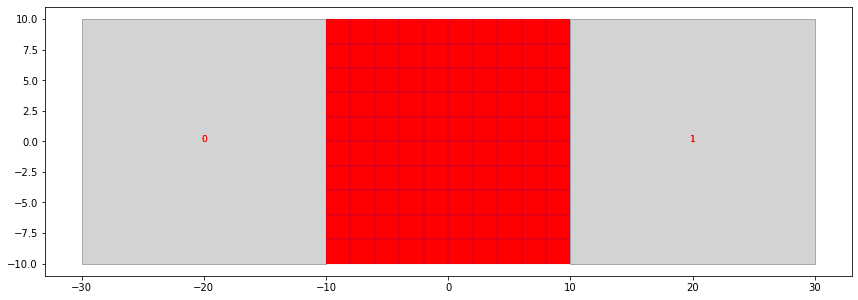

In [9]:
fig, basemap = plt.subplots(figsize=(1.75 * 8.26, 1.2 * 8.26))
buildings.plot(ax=basemap,color='lightgrey', edgecolor='dimgrey', linewidth=0.5)
grid.boundary.plot(ax=basemap, color='blue', linewidth=0.1)
CovisibleGrid.plot(ax=basemap, color='red')
buildings.apply(lambda x: basemap.annotate(
			text=x.gid, xy=x.geometry.centroid.coords[0],
			#~ text=x.HAUTEUR, xy=x.geometry.centroid.coords[0],
			color='red', size=9, ha='center'), axis=1)
buildings.apply(lambda x: basemap.annotate(
			text=x.gid, xy=x.geometry.centroid.coords[0],
			#~ text=x.HAUTEUR, xy=x.geometry.centroid.coords[0],
			color='red', size=9, ha='center'), axis=1)
plt.show()
plt.close(fig)

In [10]:
def SurfaceNormal(self): #input is the buildingsIn3d.geometry[i],than choose the polygon of one facet
    coord = self.exterior.coords
    facet_p0=np.array(coord[0])
    facet_p1=np.array(coord[1])
    facet_p2=np.array(coord[2])
    vec1 = facet_p1 - facet_p0
    vec2 = facet_p2 - facet_p1
    a = vec1[1]*vec2[2]-vec1[2]*vec2[1]
    b = vec1[2]*vec2[0]-vec1[0]*vec2[2]
    c = vec1[0]*vec2[1]-vec1[1]*vec2[0]
    normal = np.array([a,b,c])
    mod = module(normal)
    n  = normal/mod
    return n

In [11]:
def module(vector):
    return np.sqrt(np.dot(np.array(vector),np.array(vector)))

In [12]:
def isa(face1,face2):#view factor from 1 to 2
    n1=SurfaceNormal(face1.geometry)
    n2=SurfaceNormal(face2.geometry)
    a2=area3d(face2.geometry)
    vec_R=np.array([face1.CentroidPoint.x-face2.CentroidPoint.x,face1.CentroidPoint.y-face2.CentroidPoint.y,face1.CentroidPoint.z-face2.CentroidPoint.z])
    vf=-a2*np.dot(n1,vec_R)*np.dot(n2,vec_R)/(pi*module(vec_R)**4)
    return vf

In [13]:
#grid surface3d into meshes of size n*m
def grid3d(self,n,m):#n rows, m columns
    coord = self.exterior.coords
    p0=np.array(coord[0])
    p1=np.array(coord[1])
    p2=np.array(coord[2])
    p3=np.array(coord[3])
    vec1 = (p1-p0)/m
    vec2 = (p2-p1)/n
    poly=[]
    cen_p=[]
    sur_d=[]
    for i in range(n):
        for j in range(m):
            p0_t=Point(p0+j*vec1+i*vec2)
            p1_t=Point(p0+(j+1)*vec1+i*vec2)
            p2_t=Point(p0+(j+1)*vec1+(i+1)*vec2)
            p3_t=Point(p0+j*vec1+(i+1)*vec2)
            face_t = Polygon([p0_t,p1_t,p2_t,p3_t,p0_t])
            poly.append(face_t)
            cen_p.append(centroid(face_t))
            sur_d.append(Surface_diameter(face_t))
    self_grid=GeoDataFrame({'geometry': poly},crs='epsg:2154')
    self_grid['CentroidPoint']=cen_p
    self_grid['diameter']=sur_d
    return self_grid

In [14]:
#Subdivide function
def isFiveTimeRuleOk(f1,f2):
    return distance3d(f1.CentroidPoint,f2.CentroidPoint) >= 5*f1.diameter

def Subdivide(f1,f2): #f1 is the emitting surface, f2 is the target surface
    if isFiveTimeRuleOk(f1,f2):
        return [f1]
    else:
        result = []
        f_grid = grid3d(f1.geometry,2,2)
        for i in range(len(f_grid)):
            if isFiveTimeRuleOk(f_grid.iloc[i],f2):
                result.append(f_grid.iloc[i])
            else:
                result += Subdivide(f_grid.iloc[i],f2)
        return result

In [15]:
#get area from 3d polygon
def area3d(self):
    coord = self.exterior.coords
    d1 = distance3d(Point(coord[0]),Point(coord[1]))
    d2 = distance3d(Point(coord[1]),Point(coord[2]))
    return d1*d2

In [16]:
#select one wall as our study surface
testwall = GeoDataFrame.copy(SidewallsIn3d.loc[(SidewallsIn3d.gid==0) & (SidewallsIn3d.fid==0)])
testwall = testwall.reset_index(drop=True)
testwall2 = GeoDataFrame.copy(SidewallsIn3d.loc[(SidewallsIn3d.gid==1) & (SidewallsIn3d.fid==2)])
testwall2 = testwall2.reset_index(drop=True)

In [17]:
#Create DataFrame to save viewfactor
namelist=[]
for i in range(len(SidewallsIn3d)):
    gid_name = SidewallsIn3d.loc[i,'gid']
    fid_name = SidewallsIn3d.loc[i,'fid']
    namelist.append("Sidewallsgid{gid_name}fid{fid_name}".format(gid_name=gid_name,fid_name=fid_name))
for j in range(len(GridIn3d)):
    gid_name2 = GridIn3d.loc[j,'gid']
    namelist.append("Gridgid{gid_name2}".format(gid_name2=gid_name2))
    
ViewFactorFrame = pd.DataFrame(np.zeros((len(SidewallsIn3d)+len(GridIn3d),len(SidewallsIn3d)+len(GridIn3d))))
ViewFactorFrame.columns = namelist
ViewFactorFrame.index = namelist

In [18]:
%%time
#frome surface gid=0,fid=0
constant = area3d(testwall.iloc[0].geometry)
viewfactor=[]
for i in range(len(CovisibleGrid)):
    list_sub = Subdivide(testwall.iloc[0],CovisibleGrid.iloc[i])
    testgeo = GeoDataFrame(list_sub)
    testgeo.reset_index(drop=True,inplace=True)
    area = [area3d(item) for item in testgeo.geometry]
    testgeo['area']= area
    vf_isa=[]
    for j in range(len(testgeo)):
        vf_isa.append(isa(testgeo.iloc[j],CovisibleGrid.iloc[i])*testgeo.diameter[j]**2/(2*constant))
    viewfactor.append(sum(vf_isa))
CovisibleGrid['vf_isa']=viewfactor

CPU times: total: 1min 24s
Wall time: 1min 24s


In [19]:
%%time
#frome surface gid=0,fid=0
constant = area3d(testwall.iloc[0].geometry)
viewfactor=[]
for i in range(len(CovisibleGrid)):
    list_sub = Subdivide(testwall.iloc[0],CovisibleGrid.iloc[i])
    testgeo = GeoDataFrame(list_sub)
    testgeo.reset_index(drop=True,inplace=True)
    area = [area3d(item) for item in testgeo.geometry]
    testgeo['area']= area
    vf_isa=[]
    for j in range(len(testgeo)):
        vf_isa.append(isa(testgeo.iloc[j],CovisibleGrid.iloc[i])*testgeo.diameter[j]**2/(2*constant))
    ViewFactorFrame.loc['Sidewallsgid{a}fid{b}'.format(a=0,b=0),'Gridgid{c}'.format(c=i)]=sum(vf_isa)
    ViewFactorFrame.loc['Gridgid{c}'.format(c=i),'Sidewallsgid{a}fid{b}'.format(a=0,b=0)]=sum(vf_isa)*constant/area3d(CovisibleGrid.iloc[i].geometry)
#CovisibleGrid['vf_isa']=viewfactor

CPU times: total: 1min 24s
Wall time: 1min 24s


In [20]:
%%time
#frome surface gid=0,fid=0
constant = area3d(testwall2.iloc[0].geometry)
viewfactor=[]
for i in range(len(CovisibleGrid)):
    list_sub = Subdivide(testwall2.iloc[0],CovisibleGrid.iloc[i])
    testgeo = GeoDataFrame(list_sub)
    testgeo.reset_index(drop=True,inplace=True)
    area = [area3d(item) for item in testgeo.geometry]
    testgeo['area']= area
    vf_isa=[]
    for j in range(len(testgeo)):
        vf_isa.append(isa(testgeo.iloc[j],CovisibleGrid.iloc[i])*testgeo.diameter[j]**2/(2*constant))
    ViewFactorFrame.loc['Sidewallsgid{a}fid{b}'.format(a=1,b=2),'Gridgid{c}'.format(c=i)]=sum(vf_isa)
    ViewFactorFrame.loc['Gridgid{c}'.format(c=i),'Sidewallsgid{a}fid{b}'.format(a=1,b=2)]=sum(vf_isa)*constant/area3d(CovisibleGrid.iloc[i].geometry)
    viewfactor.append(sum(vf_isa))
CovisibleGrid['vf_isa_2']=viewfactor

CPU times: total: 1min 24s
Wall time: 1min 24s


In [21]:
ViewFactorFrame.loc['Sidewallsgid{a}fid{b}'.format(a=1,b=2),'Sidewallsgid{a}fid{b}'.format(a=0,b=0)]=0.1998
ViewFactorFrame.loc['Sidewallsgid{a}fid{b}'.format(a=0,b=0),'Sidewallsgid{a}fid{b}'.format(a=1,b=2)]=0.1998

In [23]:
scene1 = ToUnstructuredGrid([CovisibleGrid,buildingsIn3d],'vf_isa_2').run()
scene1.plot(scalars='vf_isa_2',cmap='gist_earth',show_edges=True,
	show_scalar_bar=True, point_size=5.0, render_points_as_spheres=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Shortwave Radiation

In [24]:
#direct and diffuse irradiance of each sensor(using Perez method)
from t4gpd.energy.Perez import Perez
from pysolar.solar import *
from datetime import *
from t4gpd.commons.AngleLib import AngleLib
from t4gpd.commons.DatetimeLib import DatetimeLib

In [25]:
def SunbeamVector(altitude_angle,azimuth_angle):#get the sunbeam vector depending on the altitude and azimuth angle
    vector_sun_x = sin(azimuth_angle)*cos(altitude_angle)
    vector_sun_y = cos(azimuth_angle)*cos(altitude_angle)
    vector_sun_z = sin(altitude_angle)
    vector_sun = np.array([vector_sun_x,vector_sun_y,vector_sun_z])
    return vector_sun

In [26]:
def STEvenPoints(face,n,m): #row=n, column=m
    p = face.exterior.coords
    vec1 = np.array(p[2])-np.array(p[1])
    vec2 = np.array(p[1])-np.array(p[0])
    L1 = vec1/n
    L2 = vec2/m
    s = []
    normal = []
    for i in range(1,n+1):
        for j in range(1,m+1):
            point_1 = np.array(p[0])+L2*(j-1)+L1*(i-1)
            point_2 = np.array(p[0])+L2*j+L1*i
            point_c = Point((point_1+point_2)/2)
            s.append(point_c)
            normal.append(SurfaceNormal(face))
    p_geodata = GeoDataFrame({'geometry':s},crs='epsg:2154')
    p_geodata['NormalVector'] = normal
    return p_geodata

In [27]:
def Sunlit2(sunbeam,point,buildings,normal):
    if np.dot(sunbeam,normal)<0:
        return False
    else:
        p = np.array([point.x,point.y,point.z])
        sun = sunbeam*100+p
        covisible, ray = RayCasting3Lib.areCovisibleIn3D(point, Point(sun), buildings, 'HAUTEUR')
        return covisible

In [28]:
#create sensors on study surfaces
sensors0 = STEvenPoints(testwall.geometry[0],10,10)
sensors1 = STEvenPoints(testwall2.geometry[0],10,10)
sensors_grid = GeoDataFrame({'geometry':GridIn3d.CentroidPoint},crs='epsg:2154')
normal_grid = [np.array([0,0,1]) for item in range(len(sensors_grid))]
sensors_grid['NormalVector'] = normal_grid

In [100]:
#Write a function of shortwave radiation,surface with n*m sensors
def Shortwave(surface,n,m,latitude,longitude,date,buildings,delta,epsilon,albedo):
    surface = surface.reset_index(drop=True)
    sensors = STEvenPoints(surface.geometry[0],n,m)
    altitude_angle = AngleLib.toRadians(get_altitude(latitude,longitude,date))
    azimuth_angle = AngleLib.toRadians(get_azimuth(latitude,longitude,date))
    sunbeam = SunbeamVector(altitude_angle,azimuth_angle)
    sunhit = [Sunlit2(sunbeam,sensors.geometry[i],buildings,sensors.NormalVector[i]) for i in range(len(sensors))]
    sensors['Sunhit'] = sunhit
    
    days = date.timetuple().tm_yday
    Dir = Perez.directSolarIrradiance(altitude_angle,days,delta,epsilon)
    Dif = Perez.diffuseSolarIrradiance(altitude_angle,days,delta)
    
    Dir1=[]#direct solar radiation
    area_surface = area3d(surface.geometry[0])
    area_grid = area_surface/(n*m)
    for i in range(len(sensors)):
        if sensors.Sunhit[i]==True:
            Dir1.append(Dir*abs(cosVectorAngle(sunbeam,sensors.NormalVector[i]))*area_grid/area_surface)#depends on size of cells
    DirectSolarRadiation = sum(Dir1)
    
    from t4gpd.morph.geoProcesses.SkyViewFactor import SkyViewFactor
    from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
    op = SkyViewFactor(buildings,nRays=64,maxRayLen=100,elevationFieldname='HAUTEUR',method=2018,background=True)
    sensors = STGeoProcess(op,sensors).run()
    
    Dif1=[]#diffuse solar radiation
    for j in range(len(sensors)):
        Dif1.append(Dif*sensors.svf[j]*area_grid/area_surface)
    DiffuseSolarRadiation= sum(Dif1)
    
    ShortwaveRadiation = (DiffuseSolarRadiation+DirectSolarRadiation)*albedo
    return ShortwaveRadiation

In [105]:
latitude = 47.16
longitude = -1.60
date = datetime(2020,6,21,9,10,tzinfo=timezone.utc)
altitude_angle = AngleLib.toRadians(get_altitude(latitude,longitude,date))
azimuth_angle = AngleLib.toRadians(get_azimuth(latitude,longitude,date))
sunbeam = SunbeamVector(altitude_angle,azimuth_angle)

In [106]:
#save sunhits
sunhit_0 = [Sunlit2(sunbeam,sensors0.geometry[i],buildings,sensors0.NormalVector[i]) for i in range(len(sensors0))]
sensors0['Sunhit'] = sunhit_0
sunhit_1 = [Sunlit2(sunbeam,sensors1.geometry[j],buildings,sensors1.NormalVector[j]) for j in range(len(sensors1))]
sensors1['Sunhit'] = sunhit_1
sunhit_grid = [Sunlit2(sunbeam,sensors_grid.geometry[t],buildings,sensors_grid.NormalVector[t]) for t in range(len(sensors_grid))]
sensors_grid['Sunhit'] = sunhit_grid

In [107]:
# get direct and diffuse solar irradiance, return W/m^2?
from t4gpd.energy.Perez import Perez
days = date.timetuple().tm_yday
delta = 0.12 #sky's brightness (Perez et al.,1993)
epsilon = 6.3 #sky's clearness (Perez et al.,1993)
Dir = Perez.directSolarIrradiance(altitude_angle,days,delta,epsilon)
Dif = Perez.diffuseSolarIrradiance(altitude_angle,days,delta)

In [108]:
def cosVectorAngle(vector1,vector2):#calculate the angle between two vectors
    unit_vector1 = vector1/np.linalg.norm(vector1)
    unit_vector2 = vector2/np.linalg.norm(vector2)
    dot_vector = np.dot(unit_vector1,unit_vector2)
    return dot_vector

In [109]:
#Calculate Direct accpeted by surfaces, here unit of DirectSolarR is W/m2
Dir0=[]
Dir1=[]
Dir_grid=[]
for i in range(len(sensors0)):
    if sensors0.Sunhit[i]==True:
        Dir0.append(Dir*abs(cosVectorAngle(sunbeam,sensors0.NormalVector[i]))*4)
testwall['DirectSolarRadiation'] = sum(Dir0)/area3d(testwall.geometry[0])
for j in range(len(sensors1)):
    if sensors1.Sunhit[j]==True:
        Dir1.append(Dir*abs(cosVectorAngle(sunbeam,sensors1.NormalVector[j]))*4)
testwall2['DirectSolarRadiation'] = sum(Dir1)/area3d(testwall2.geometry[0])
for g in range(len(sensors_grid)):
    if sensors_grid.Sunhit[g]==True:
        Dir_grid.append(Dir*abs(cosVectorAngle(sunbeam,sensors_grid.NormalVector[g])))
    else:
        Dir_grid.append(0)
GridIn3d['DirectSolarRadiation'] = Dir_grid

In [68]:
#Calculate SVF of each sensors
from t4gpd.morph.geoProcesses.SkyViewFactor import SkyViewFactor
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
op = SkyViewFactor(buildings,nRays=64,maxRayLen=100,
                  elevationFieldname='HAUTEUR',method=2018,background=True)
sensors0 = STGeoProcess(op,sensors0).run()
sensors1 = STGeoProcess(op,sensors1).run()
sensors_grid = STGeoProcess(op,sensors_grid).run()

SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0


In [110]:
#Calculate Diffuse accpeted by surfaces
Dif0=[]
Dif1=[]
Dif_grid=[]
for i in range(len(sensors0)):
    Dif0.append(Dif*sensors0.svf[i]*4)
testwall['DiffuseSolarRadiation'] = sum(Dif0)/area3d(testwall.geometry[0])
for j in range(len(sensors1)):
    Dif1.append(Dif*sensors1.svf[j]*4)
testwall2['DiffuseSolarRadiation'] = sum(Dif1)/area3d(testwall2.geometry[0])
for g in range(len(sensors_grid)):
    Dif_grid.append(Dif*sensors_grid.svf[g])
GridIn3d['DiffuseSolarRadiation'] = Dif_grid

In [111]:
#Short-wave radiation,here without considering the reflected radiation
al_b = 0.6 #whit painted buildings
al_g = 0.1 #albedo of asphalt
testwall['ShortwaveRadiation'] = (testwall.DiffuseSolarRadiation[0]+testwall.DirectSolarRadiation[0])*al_b
testwall2['ShortwaveRadiation'] = (testwall2.DiffuseSolarRadiation[0]+testwall2.DirectSolarRadiation[0])*al_b
shortwave_grid = [(GridIn3d.DiffuseSolarRadiation[x]+GridIn3d.DirectSolarRadiation[x])*al_g for x in range(len(GridIn3d))]
GridIn3d['ShortwaveRadiation'] = shortwave_grid

In [130]:
scene3 = ToUnstructuredGrid([testwall,testwall2,GridIn3d,sensors0,sensors1,sensors_grid],'ShortwaveRadiation').run()
scene3.plot(scalars='ShortwaveRadiation',cmap='gist_earth',show_edges=False,
	show_scalar_bar=True, point_size=5.0, render_points_as_spheres=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [225]:
testwall

,geometry,gid,fid,CentroidPoint,diameter,DirectSolarRadiation,DiffuseSolarRadiation,ShortwaveRadiation,T0,LongwaveRadiation,AtmosphereLongwaveRadiation,EmittingLongwaveRadiation,HeatCapacity,MassPerUnitArea
0,"POLYGON Z ((-10.000 -10.000 0.000, -10.000 10....",0,0,POINT Z (-10 0 10),28.284271,585.446751,48.534048,380.388479,15,54.07199,161.008421,58.633904,880,2400


# Longwave Radiation

In [44]:
#rh is the relativve humidity(%),ta is the air temperature
def VaporPressure(ta,rh):
    vp = rh*6.1121*exp((18.678-ta/234.4)*ta/(257.14+ta))
    return vp

In [122]:
#Atmosphere longwave radiation,we set N(degree of cloudiness)=8,all air temperature unite is ℃,rh is the relativve humidity(%),
def AtmoLongRadiation(ta,N,rh):
    p = VaporPressure(ta,rh)
    #ta is the air temperature; N is the degree of cloudiness; p is the vapor pressure(hPa)
    con = 5.67e-8#Stefan-Boltzmann constant
    LR = con*(ta+273.15)**4*(0.82-0.25*10**(-0.0945*p))*(1+0.21*(N/8)**2.5)
    return LR

# Convection

Convection depends on the wind speed. Since we cannot simulate the wind speed under the city canopy, we shall give a constant value.The convection coefficient h is estimated as h = 4uair + 4. Wind speed is according to the weather data at each time step.

In [50]:
def CovectionCoefficient(uair):
    return 4*uair+4

In [64]:
#air temperature,wind speed,surface temperature
def Convection(ta,uair,ts):
    h = CovectionCoefficient(uair)
    qv = h*(ta-ts)
    return qv

# Conductive Heat Transmission

In our case we will ignore this section

# Heat Balance Equation

In this section, we will focus on the variation of surface temperature. We shall derive these values through heat balance equation.
Qt+Qm+Qr+Qv+Ql=0

In [212]:
#First we set our initial value
t_va = 0.1 #temperature variation threhold
ta = 20 #air temperature
uair = 6 #wind speed
rh = 0.4 #relative humidity
con = 5.67e-8 #Stefan-Boltzmann constant
N = 8 #cloudiness
testwall['T0']=15
testwall['HeatCapacity']=880#Ordinary Concrete J/kg.K
testwall['MassPerUnitArea']=2400
testwall2['T0']=18
testwall2['HeatCapacity']=880
testwall2['MassPerUnitArea']=2400
grid_t0 = [10 for i in range(len(GridIn3d))]
grid_hc = [840 for i in range(len(GridIn3d))]
grid_mass = [2243 for i in range(len(GridIn3d))]
GridIn3d['T0']=grid_t0
GridIn3d['HeatCapacity']=grid_hc
GridIn3d['MassPerUnitArea']=grid_mass

In [164]:
#calculate the longwave radiation without considering other emitting surface
emi_b = 0.3 #emissivity of building
emi_g = 0.7 #emissivity of ground
AtmoLong0=[] #atmosphere long wave radiation
AtmoLong1=[]
AtmoLong_grid=[]
emitLong_grid=[]
Long_grid=[]

for i in range(len(sensors0)):
    a0=AtmoLongRadiation(ta,N,rh)*sensors0.svf[i]
    AtmoLong0.append(a0)
e0=0.5*emi_b*con*(testwall.T0[0]+273.15)**4
testwall['AtmosphereLongwaveRadiation']=np.mean(AtmoLong0)
testwall['EmittingLongwaveRadiation']=e0
testwall['LongwaveRadiation'] = np.mean(AtmoLong0)*(1-emi_b)-e0

for j in range(len(sensors1)):
    a1=AtmoLongRadiation(ta,N,rh)*sensors1.svf[j]
    AtmoLong1.append(a1)
e1=0.5*emi_b*con*(testwall2.T0[0]+273.15)**4
testwall2['AtmosphereLongwaveRadiation']=np.mean(AtmoLong1)
testwall2['EmittingLongwaveRadiation']=e1
testwall2['LongwaveRadiation'] = np.mean(AtmoLong1)*(1-emi_b)-e1

for g in range(len(sensors_grid)):
    a_grid=AtmoLongRadiation(ta,N,rh)*sensors_grid.svf[g]
    e_grid=0.5*emi_g*con*(GridIn3d.T0[g]+273.15)**4
    AtmoLong_grid.append(a_grid)
    emitLong_grid.append(e_grid)
    Long_grid.append(a_grid*(1-emi_g)-e_grid)
GridIn3d['AtmosphereLongwaveRadiation']=AtmoLong_grid
GridIn3d['EmittingLongwaveRadiation']=emitLong_grid
GridIn3d['LongwaveRadiation'] = Long_grid

In [154]:
scene4 = ToUnstructuredGrid([testwall,testwall2,GridIn3d,sensors0,sensors1,sensors_grid],'LongwaveRadiation').run()
scene4.plot(scalars='LongwaveRadiation',cmap='gist_earth',show_edges=False,
	show_scalar_bar=True, point_size=5.0, render_points_as_spheres=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [245]:
#here we don't consider the reflected radiation
def delta_temperature(surface,ta,uair):
    thickness=0.1
    density = 2076
    h=surface.HeatCapacity
    m=surface.MassPerUnitArea
    Qr=surface.ShortwaveRadiation[0]
    Qv=Convection(ta,uair,surface.T0[0])
    Ql=surface.LongwaveRadiation[0]
    Qe=SurfaceLongwave(surface,ViewFactorFrame)
    delta_t = (Qr+Qv+Ql+Qe)/(thickness*density*h)
    return Qe

In [242]:
#we assume calculate testwall, gid=0,fid=0
def SurfaceLongwave(surface,ViewFactorFrame):
    longwave=[]
    for i in range(len(GridIn3d)):
        vf_i = ViewFactorFrame.loc['Gridgid{c}'.format(c=i),'Sidewallsgid{gidtest}fid{fidtest}'.format(gidtest=0,fidtest=0)]
        longwave.append(GridIn3d.EmittingLongwaveRadiation[i]*(1-emi_b)*vf_i)
    longwave.append(testwall2.EmittingLongwaveRadiation[0]*(1-emi_b)*0.1998)
    return sum(longwave)

In [246]:
delta_temperature(testwall,ta,uair)

1795.8288847721094

In [104]:
%%time
Short_Grid=[]
for i in range(len(GridIn3d)):
    grid_i = GeoDataFrame.copy(GridIn3d.loc[(GridIn3d.index==i)])
    Short_Grid.append(Shortwave(grid_i,1,1,47.16,-1.6,date,buildings,delta,epsilon,al_g))

SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0
SVF calculation method: Bernard et al. (2018), nRays = 64, maxRayLen = 100.0

In [230]:
#ViewFactorFrame.loc['Sidewallsgid0fid0','Sidewallsgid1fid2']
ViewFactorFrame.loc['Sidewallsgid{gidtest}fid{fidtest}'.format(gidtest=0,fidtest=0),'Sidewallsgid1fid2']

0.1998

In [233]:
testwall

,geometry,gid,fid,CentroidPoint,diameter,DirectSolarRadiation,DiffuseSolarRadiation,ShortwaveRadiation,T0,LongwaveRadiation,AtmosphereLongwaveRadiation,EmittingLongwaveRadiation,HeatCapacity,MassPerUnitArea
0,"POLYGON Z ((-10.000 -10.000 0.000, -10.000 10....",0,0,POINT Z (-10 0 10),28.284271,585.446751,48.534048,380.388479,15,54.07199,161.008421,58.633904,880,2400
